# Tutorial de PySpark

 1. [Creacción SparkSession](#spark)
 2. [DataFrame](#df)
 3. [Exploración de los datos](#exp_dat)
 4. [Análisis variables](#anal_var)
 5. [Funciones](#func)
 6. [Valores nulos o NaN](#nan)
 7. [DateTime](#date)


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as f

import matplotlib.pyplot as plt
import pandas as pd

<img src=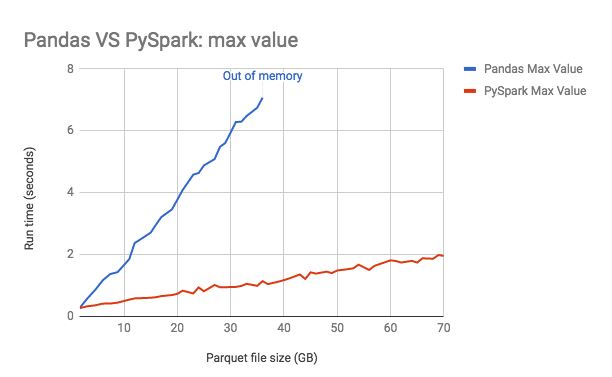>

## Creacción SparkSession <a class="anchor" id="spark"></a>

SparkSession es el punto de entrada a PySpark, internamente crea SparkContext que es el motor interno que permite las conexiones con los clusters.

In [2]:
spark = SparkSession.builder\
        .master("local[8]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [3]:
sc = spark.sparkContext

## DataFrame <a class="anchor" id="df"></a>

Comenzamos **cargando los datos** a un DataFrame. Por defecto todas las variables son consideradas de tipo String, hemos de especificar inferSchema=True para actualizarlos. 

In [4]:
df = spark.read.csv('Data/pokemon.csv', header = True, inferSchema = True)

Especificar el **schema** al cargar los datos en un DataFrame puede ser mejor opción que inferSchema

In [5]:
schema = StructType([StructField("id", IntegerType(), True), 
                     StructField("Name", StringType(), True),
                     StructField("Type_1", StringType(), True),
                     StructField("Type_2", StringType(), True),
                     StructField("Total", IntegerType(), True),
                     StructField("HP", IntegerType(), True),
                     StructField("Attack", IntegerType(), True),
                     StructField("Defense", IntegerType(), True),
                     StructField("Sp_Atk", IntegerType(), True),
                     StructField("Sp_Def", IntegerType(), True),
                     StructField("Speed", IntegerType(), True),
                     StructField("Generation", IntegerType(), True),
                     StructField("Legendary", BooleanType(), True)])

df = spark.read.csv('Data/pokemon.csv', header = True, schema = schema)

In [6]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Type_1: string (nullable = true)
 |-- Type_2: string (nullable = true)
 |-- Total: integer (nullable = true)
 |-- HP: integer (nullable = true)
 |-- Attack: integer (nullable = true)
 |-- Defense: integer (nullable = true)
 |-- Sp_Atk: integer (nullable = true)
 |-- Sp_Def: integer (nullable = true)
 |-- Speed: integer (nullable = true)
 |-- Generation: integer (nullable = true)
 |-- Legendary: boolean (nullable = true)



In [7]:
df.show(3)

+---+---------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
| id|     Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+---------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  1|Bulbasaur| Grass|Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|
|  2|  Ivysaur| Grass|Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|
|  3| Venusaur| Grass|Poison|  525| 80|    82|     83|   100|   100|   80|         1|    false|
+---+---------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
only showing top 3 rows



Si el DataFrame es grande utilizaremos <i>truncate</i> para que las columnas no se trunquen y <i>vertical</i> para una salida de datos en vertical.

In [8]:
df.show(n=2, truncate=False, vertical=True)

-RECORD 0---------------
 id         | 1         
 Name       | Bulbasaur 
 Type_1     | Grass     
 Type_2     | Poison    
 Total      | 318       
 HP         | 45        
 Attack     | 49        
 Defense    | 49        
 Sp_Atk     | 65        
 Sp_Def     | 65        
 Speed      | 45        
 Generation | 1         
 Legendary  | false     
-RECORD 1---------------
 id         | 2         
 Name       | Ivysaur   
 Type_1     | Grass     
 Type_2     | Poison    
 Total      | 405       
 HP         | 60        
 Attack     | 62        
 Defense    | 63        
 Sp_Atk     | 80        
 Sp_Def     | 80        
 Speed      | 60        
 Generation | 1         
 Legendary  | false     
only showing top 2 rows



Con `.collect()` se obtienen todos los elementos de un DataFrame como un objeto tipo `list` en el que cada valor es del tipo `pyspark.sql.types.Row`. Esta forma de acceder a los datos será interesante para las visualizaciones.

In [9]:
dataCollect = df.collect()
dataCollect[0:5]

[Row(id=1, Name='Bulbasaur', Type_1='Grass', Type_2='Poison', Total=318, HP=45, Attack=49, Defense=49, Sp_Atk=65, Sp_Def=65, Speed=45, Generation=1, Legendary=False),
 Row(id=2, Name='Ivysaur', Type_1='Grass', Type_2='Poison', Total=405, HP=60, Attack=62, Defense=63, Sp_Atk=80, Sp_Def=80, Speed=60, Generation=1, Legendary=False),
 Row(id=3, Name='Venusaur', Type_1='Grass', Type_2='Poison', Total=525, HP=80, Attack=82, Defense=83, Sp_Atk=100, Sp_Def=100, Speed=80, Generation=1, Legendary=False),
 Row(id=3, Name='VenusaurMega Venusaur', Type_1='Grass', Type_2='Poison', Total=625, HP=80, Attack=100, Defense=123, Sp_Atk=122, Sp_Def=120, Speed=80, Generation=1, Legendary=False),
 Row(id=4, Name='Charmander', Type_1='Fire', Type_2=None, Total=309, HP=39, Attack=52, Defense=43, Sp_Atk=60, Sp_Def=50, Speed=65, Generation=1, Legendary=False)]

In [10]:
for row in dataCollect[0:5]:
    print(row['Name'] + "," +str(row['Type_1']))

Bulbasaur,Grass
Ivysaur,Grass
Venusaur,Grass
VenusaurMega Venusaur,Grass
Charmander,Fire


Para **añadir un fila** al DataFrame crearemos un DataFrame secundario para unirlo con `.union()`

In [11]:
newRow = spark.createDataFrame([(2,"Ivysaur","Grass","Poison",405,60,62,63,80,80,60,1,False)], 
                               ['#','Name','Type_1','Type_2','Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary'])

newRow.show()

df2 = df.union(newRow) 

+---+-------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
|  #|   Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp. Atk|Sp. Def|Speed|Generation|Legendary|
+---+-------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+
|  2|Ivysaur| Grass|Poison|  405| 60|    62|     63|     80|     80|   60|         1|    false|
+---+-------+------+------+-----+---+------+-------+-------+-------+-----+----------+---------+



Para eliminar los **duplicados** existe una función similar a `.drop_duplicates()`

In [12]:
df2 = df2.dropDuplicates()

Podemos cargar un DataFrame con PySpark y visualizar las primeras filas con `.toPandas()`, ahorrandonos la carga en memoria de todo el DataFrame con pandas.

In [13]:
df.limit(3).toPandas()

,id,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


Para **crear un DataFrame** desde el inicio se realiza a partir de `spark.createDataFrame()`

In [14]:
pokedex = [("Bulbasaur","Grass",1,0.7),
           ("Ivysaur","Grass",2,1.0),
           ("Venusaur","Grass",3,2.0),
           ("Lugia","Psychic", 4, 5.2),
           ("Charmeleon","Fire",5,1.1),
           ("Charizard","Fire",6,1.7),
           ("Wartortle","Water",8,1.0),
           ("Blastoise","Water",9,1.6),
           ("Butterfree","Flying",10,1.1)]
 
schema = ["Name","PrimaryType","Index","Height"]
df2 = spark.createDataFrame(data=pokedex, schema = schema)
df2.show()

+----------+-----------+-----+------+
|      Name|PrimaryType|Index|Height|
+----------+-----------+-----+------+
| Bulbasaur|      Grass|    1|   0.7|
|   Ivysaur|      Grass|    2|   1.0|
|  Venusaur|      Grass|    3|   2.0|
|     Lugia|    Psychic|    4|   5.2|
|Charmeleon|       Fire|    5|   1.1|
| Charizard|       Fire|    6|   1.7|
| Wartortle|      Water|    8|   1.0|
| Blastoise|      Water|    9|   1.6|
|Butterfree|     Flying|   10|   1.1|
+----------+-----------+-----+------+



## Exploración de los datos <a class="anchor" id="exp_dat"></a>

La funciónn `summary()` sería la análoga en pandas a `describe()`

In [15]:
df.summary().show()

+-------+------------------+----------------+------+------+------------------+------------------+-----------------+------------------+----------------+-----------------+------------------+------------------+
|summary|                id|            Name|Type_1|Type_2|             Total|                HP|           Attack|           Defense|          Sp_Atk|           Sp_Def|             Speed|        Generation|
+-------+------------------+----------------+------+------+------------------+------------------+-----------------+------------------+----------------+-----------------+------------------+------------------+
|  count|               800|             800|   800|   414|               800|               800|              800|               800|             800|              800|               800|               800|
|   mean|         362.81375|            null|  null|  null|          435.1025|          69.25875|         79.00125|           73.8425|           72.82|          71.9025

`.count()` cuenta el número de filas

In [16]:
df.count()

800

`.columns()` nombre de las columnas

In [17]:
df.columns

['id',
 'Name',
 'Type_1',
 'Type_2',
 'Total',
 'HP',
 'Attack',
 'Defense',
 'Sp_Atk',
 'Sp_Def',
 'Speed',
 'Generation',
 'Legendary']

`.dtypes()` muestra el DateType de las columnas

In [18]:
df.dtypes

[('id', 'int'),
 ('Name', 'string'),
 ('Type_1', 'string'),
 ('Type_2', 'string'),
 ('Total', 'int'),
 ('HP', 'int'),
 ('Attack', 'int'),
 ('Defense', 'int'),
 ('Sp_Atk', 'int'),
 ('Sp_Def', 'int'),
 ('Speed', 'int'),
 ('Generation', 'int'),
 ('Legendary', 'boolean')]

`.withColumn()` toma dos parametros (nombre_columna, datos) y crea una nueva columna. `lit()` asigna una constante o valor literal.

In [19]:
df = df.withColumn("Game", lit("Pokemon"))
df.show(8)

+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+-------+
| id|                Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|   Game|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+-------+
|  1|           Bulbasaur| Grass|Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|Pokemon|
|  2|             Ivysaur| Grass|Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|Pokemon|
|  3|            Venusaur| Grass|Poison|  525| 80|    82|     83|   100|   100|   80|         1|    false|Pokemon|
|  3|VenusaurMega Venu...| Grass|Poison|  625| 80|   100|    123|   122|   120|   80|         1|    false|Pokemon|
|  4|          Charmander|  Fire|  null|  309| 39|    52|     43|    60|    50|   65|         1|    false|Pokemon|
|  5|          Charmeleon|  Fire|  null|  405| 58|    64|     58|    80|    65| 

`.withColumnRenamed()` cambia el nombre de las columnas.

In [20]:
df = df.withColumnRenamed('Game', 'GAME')
df.columns

['id',
 'Name',
 'Type_1',
 'Type_2',
 'Total',
 'HP',
 'Attack',
 'Defense',
 'Sp_Atk',
 'Sp_Def',
 'Speed',
 'Generation',
 'Legendary',
 'GAME']

`.drop()` elimina las columnas especificadas

In [21]:
df = df.drop('GAME')
df.show(2)

+---+---------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
| id|     Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+---------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  1|Bulbasaur| Grass|Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|
|  2|  Ivysaur| Grass|Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|
+---+---------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
only showing top 2 rows



### Select <a class="anchor" id="sec3_1"></a>

In [22]:
df.select("id", "Attack").show(5)

+---+------+
| id|Attack|
+---+------+
|  1|    49|
|  2|    62|
|  3|    82|
|  3|   100|
|  4|    52|
+---+------+
only showing top 5 rows



### Filter <a class="anchor" id="sec3_2"></a>
Filtra las filas en base a determinada condición.

In [23]:
df.filter((df["Type_1"] == "Water") & (df["Attack"] >= 140)).show()
# otras sintaxis: df.id == 1 ; col("id") == 1 ; "id = 1"

+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
| id|                Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|130|GyaradosMega Gyar...| Water|  Dark|  640| 95|   155|    109|    70|   130|   81|         1|    false|
|260|SwampertMega Swam...| Water|Ground|  635|100|   150|    110|    95|   110|   70|         3|    false|
|319|SharpedoMega Shar...| Water|  Dark|  560| 70|   140|     70|   110|    65|  105|         3|    false|
|382| KyogrePrimal Kyogre| Water|  null|  770|100|   150|     90|   180|   160|   90|         3|     true|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+



A continuación vemos `between`, `rlike`,  `when`

In [24]:
df.filter(df.Defense.between(5, 15)).show()

+---+---------+--------+-------+-----+---+------+-------+------+------+-----+----------+---------+
| id|     Name|  Type_1| Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+---------+--------+-------+-----+---+------+-------+------+------+-----+----------+---------+
| 63|     Abra| Psychic|   null|  310| 25|    20|     15|   105|    55|   90|         1|    false|
|113|  Chansey|  Normal|   null|  450|250|     5|      5|    35|   105|   50|         1|    false|
|172|    Pichu|Electric|   null|  205| 20|    40|     15|    35|    35|   60|         2|    false|
|174|Igglybuff|  Normal|  Fairy|  210| 90|    30|     15|    40|    20|   15|         2|    false|
|238| Smoochum|     Ice|Psychic|  305| 45|    30|     15|    85|    65|   65|         2|    false|
|242|  Blissey|  Normal|   null|  540|255|    10|     10|    75|   135|   55|         2|    false|
|440|  Happiny|  Normal|   null|  220|100|     5|      5|    15|    65|   30|         4|    false|
+---+-----

In [25]:
df.select('Name','Type_1', df.Type_1.rlike('^G').alias('Tipo empieza por G')).show(10)

+--------------------+------+------------------+
|                Name|Type_1|Tipo empieza por G|
+--------------------+------+------------------+
|           Bulbasaur| Grass|              true|
|             Ivysaur| Grass|              true|
|            Venusaur| Grass|              true|
|VenusaurMega Venu...| Grass|              true|
|          Charmander|  Fire|             false|
|          Charmeleon|  Fire|             false|
|           Charizard|  Fire|             false|
|CharizardMega Cha...|  Fire|             false|
|CharizardMega Cha...|  Fire|             false|
|            Squirtle| Water|             false|
+--------------------+------+------------------+
only showing top 10 rows



In [26]:
df2 = df.select('Name', 'Type_1','Attack','HP', f.when(df.HP >= 55, 1).otherwise(0).alias('IsBig'))
df2.show(10)

+--------------------+------+------+---+-----+
|                Name|Type_1|Attack| HP|IsBig|
+--------------------+------+------+---+-----+
|           Bulbasaur| Grass|    49| 45|    0|
|             Ivysaur| Grass|    62| 60|    1|
|            Venusaur| Grass|    82| 80|    1|
|VenusaurMega Venu...| Grass|   100| 80|    1|
|          Charmander|  Fire|    52| 39|    0|
|          Charmeleon|  Fire|    64| 58|    1|
|           Charizard|  Fire|    84| 78|    1|
|CharizardMega Cha...|  Fire|   130| 78|    1|
|CharizardMega Cha...|  Fire|   104| 78|    1|
|            Squirtle| Water|    48| 44|    0|
+--------------------+------+------+---+-----+
only showing top 10 rows



Variables continuas y categóricas con `.mean()` y `.pivot()`

In [27]:
df2.groupby('IsBig').mean('HP','Attack').show()

+-----+-----------------+-----------------+
|IsBig|          avg(HP)|      avg(Attack)|
+-----+-----------------+-----------------+
|    1|79.36379310344827|87.76551724137931|
|    0|42.61818181818182|55.89545454545455|
+-----+-----------------+-----------------+



In [28]:
df2.groupby('IsBig').pivot('Type_1').count().show()

+-----+---+----+------+--------+-----+--------+----+------+-----+-----+------+---+------+------+-------+----+-----+-----+
|IsBig|Bug|Dark|Dragon|Electric|Fairy|Fighting|Fire|Flying|Ghost|Grass|Ground|Ice|Normal|Poison|Psychic|Rock|Steel|Water|
+-----+---+----+------+--------+-----+--------+----+------+-----+-----+------+---+------+------+-------+----+-----+-----+
|    1| 42|  21|    28|      27|   13|      19|  41|     3|   19|   52|    24| 18|    78|    20|     42|  31|   21|   81|
|    0| 27|  10|     4|      17|    4|       8|  11|     1|   13|   18|     8|  6|    20|     8|     15|  13|    6|   31|
+-----+---+----+------+--------+-----+--------+----+------+-----+-----+------+---+------+------+-------+----+-----+-----+



### Aggregations <a class="anchor" id="sec3_3"></a>

In [29]:
df.groupBy('Type_1').agg(count("Name").alias("No. Total"), sum("HP").alias("Total_HP")).show()

+--------+---------+--------+
|  Type_1|No. Total|Total_HP|
+--------+---------+--------+
|   Water|      112|    8071|
|  Poison|       28|    1883|
|   Steel|       27|    1761|
|    Rock|       44|    2876|
|     Ice|       24|    1728|
|   Ghost|       32|    2062|
|   Fairy|       17|    1260|
| Psychic|       57|    4026|
|  Dragon|       32|    2666|
|  Flying|        4|     283|
|     Bug|       69|    3925|
|Electric|       44|    2631|
|    Fire|       52|    3635|
|  Ground|       32|    2361|
|    Dark|       31|    2071|
|Fighting|       27|    1886|
|   Grass|       70|    4709|
|  Normal|       98|    7573|
+--------+---------+--------+



In [30]:
df.groupby('Type_1').agg({'HP':'mean'}).show()

+--------+-----------------+
|  Type_1|          avg(HP)|
+--------+-----------------+
|   Water|          72.0625|
|  Poison|            67.25|
|   Steel|65.22222222222223|
|    Rock|65.36363636363636|
|     Ice|             72.0|
|   Ghost|          64.4375|
|   Fairy|74.11764705882354|
| Psychic|70.63157894736842|
|  Dragon|          83.3125|
|  Flying|            70.75|
|     Bug|56.88405797101449|
|Electric|59.79545454545455|
|    Fire|69.90384615384616|
|  Ground|         73.78125|
|    Dark|66.80645161290323|
|Fighting|69.85185185185185|
|   Grass|67.27142857142857|
|  Normal|77.27551020408163|
+--------+-----------------+



### Sort <a class="anchor" id="sec3_4"></a>

In [31]:
df.sort("HP", ascending=False).show(10)

+---+--------------------+-------+------+-----+---+------+-------+------+------+-----+----------+---------+
| id|                Name| Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+--------------------+-------+------+-----+---+------+-------+------+------+-----+----------+---------+
|242|             Blissey| Normal|  null|  540|255|    10|     10|    75|   135|   55|         2|    false|
|113|             Chansey| Normal|  null|  450|250|     5|      5|    35|   105|   50|         1|    false|
|202|           Wobbuffet|Psychic|  null|  405|190|    33|     58|    33|    58|   33|         2|    false|
|321|             Wailord|  Water|  null|  500|170|    90|     45|    90|    45|   60|         3|    false|
|594|           Alomomola|  Water|  null|  470|165|    75|     80|    40|    45|   65|         5|    false|
|143|             Snorlax| Normal|  null|  540|160|   110|     65|    65|   110|   30|         1|    false|
|426|            Drifblim|  

## Análisis variables <a class="anchor" id="anal_var"></a>

Análogo a `.value_counts()` 

In [32]:
df2 = df.groupBy('Type_1').count().orderBy('count', ascending=False)
df2.show()

+--------+-----+
|  Type_1|count|
+--------+-----+
|   Water|  112|
|  Normal|   98|
|   Grass|   70|
|     Bug|   69|
| Psychic|   57|
|    Fire|   52|
|    Rock|   44|
|Electric|   44|
|  Ground|   32|
|  Dragon|   32|
|   Ghost|   32|
|    Dark|   31|
|  Poison|   28|
|Fighting|   27|
|   Steel|   27|
|     Ice|   24|
|   Fairy|   17|
|  Flying|    4|
+--------+-----+



Visualizamos con un **plot.bar** el `.value_counts()` cargando el DataFrame en memoria con pandas

<AxesSubplot:xlabel='Type_1'>

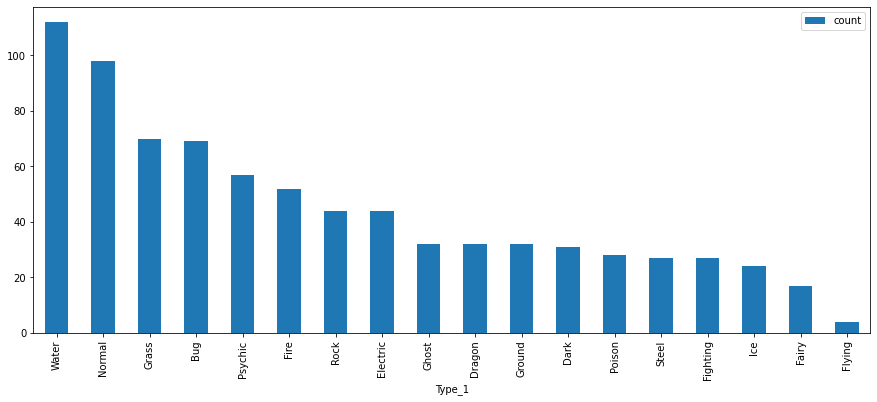

In [33]:
df2.toPandas().plot.bar(x='Type_1',figsize=(15, 6))

Análogo a `.describe()`

In [34]:
df.select('Attack').summary().show()

+-------+-----------------+
|summary|           Attack|
+-------+-----------------+
|  count|              800|
|   mean|         79.00125|
| stddev|32.45736586949845|
|    min|                5|
|    25%|               55|
|    50%|               75|
|    75%|              100|
|    max|              190|
+-------+-----------------+



Análogo a `.unique()`

In [35]:
df.select("Generation").distinct().show()

+----------+
|Generation|
+----------+
|         1|
|         6|
|         3|
|         5|
|         4|
|         2|
+----------+



Número de valores distintos que toma una variable al agruparla a partir de otra

In [36]:
df.groupby("Type_2").agg(countDistinct("HP")).show()

+--------+---------+
|  Type_2|count(HP)|
+--------+---------+
|   Water|       12|
|  Poison|       11|
|   Steel|       15|
|    Rock|       11|
|     Ice|        9|
|    null|       74|
|   Ghost|       10|
|   Fairy|       16|
| Psychic|       16|
|  Dragon|       16|
|  Flying|       34|
|     Bug|        3|
|Electric|        6|
|    Fire|        7|
|  Ground|       20|
|    Dark|       11|
|Fighting|       15|
|   Grass|       18|
|  Normal|        3|
+--------+---------+



**plt.bar** utilizando `.collect()`

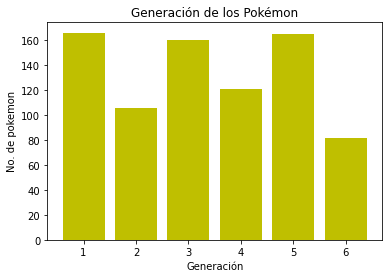

In [37]:
ejes = df.groupBy('Generation').count().sort('Generation') # variables y cantidades
valx = [str(row['Generation']) for row in ejes.collect()] # obtenemos los valores para el eje de abscisas
valy = [int(row['count']) for row in ejes.collect()] # obtenemos los valores para el eje de ordenadas

plt.bar(range(len(valy)), valy, color="y", width = 0.8)

plt.xticks(range(len(valx)), valx)
plt.xlabel("Generación")
plt.ylabel("No. de pokemon")
plt.title("Generación de los Pokémon")
plt.show()

## Funciones definidas por el usuario (UDF) <a class="anchor" id="func"></a>

Buscamos agrupar el ataque en tres niveles:

In [38]:
def detAttack_level(attack):
    level = None

    if(attack > 100):
        level = 'high_attack'
    elif(attack > 75):
        level = 'mid_attack'
    elif(attack > 0):
        level = 'low_attack'
    else:
        level = 'invalid_attack'
    return level

Tenemos que registrar la función como UDF

In [39]:
attack_level = udf(detAttack_level, StringType())

Aplicamos la función sobre una columna determinada

In [40]:
df2 = df.withColumn("Attack_level", attack_level("Attack"))
df2.show()

+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+------------+
| id|                Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|Attack_level|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+------------+
|  1|           Bulbasaur| Grass|Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|  low_attack|
|  2|             Ivysaur| Grass|Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|  low_attack|
|  3|            Venusaur| Grass|Poison|  525| 80|    82|     83|   100|   100|   80|         1|    false|  mid_attack|
|  3|VenusaurMega Venu...| Grass|Poison|  625| 80|   100|    123|   122|   120|   80|         1|    false|  mid_attack|
|  4|          Charmander|  Fire|  null|  309| 39|    52|     43|    60|    50|   65|         1|    false|  low_attack|
|  5|          Charmeleon|  Fire|  null|

## Valores nulos o NaN <a class="anchor" id="nan"></a>

Analizamos las **columnas con valores nulos**

In [41]:
for col in df2.columns:
    print(col.ljust(10), df2.filter(df2[col].isNull()).count())

id         0
Name       0
Type_1     0
Type_2     386
Total      0
HP         0
Attack     0
Defense    0
Sp_Atk     0
Sp_Def     0
Speed      0
Generation 0
Legendary  0
Attack_level 0


**isNull()** y **inNotNull()**: nos dan las filas con valores nulos o sin ellos

In [42]:
df2 = df.filter(df["Type_2"].isNull())
df2.show(10)

+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
| id|                Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  4|          Charmander|  Fire|  null|  309| 39|    52|     43|    60|    50|   65|         1|    false|
|  5|          Charmeleon|  Fire|  null|  405| 58|    64|     58|    80|    65|   80|         1|    false|
|  7|            Squirtle| Water|  null|  314| 44|    48|     65|    50|    64|   43|         1|    false|
|  8|           Wartortle| Water|  null|  405| 59|    63|     80|    65|    80|   58|         1|    false|
|  9|           Blastoise| Water|  null|  530| 79|    83|    100|    85|   105|   78|         1|    false|
|  9|BlastoiseMega Bla...| Water|  null|  630| 79|   103|    120|   135|   115|   78|         1|    false|
| 10|            Caterpie|   Bug|  nu

In [43]:
df2 = df.filter(df["Type_2"].isNotNull())
df2.show(10)

+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
| id|                Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  1|           Bulbasaur| Grass|Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|
|  2|             Ivysaur| Grass|Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|
|  3|            Venusaur| Grass|Poison|  525| 80|    82|     83|   100|   100|   80|         1|    false|
|  3|VenusaurMega Venu...| Grass|Poison|  625| 80|   100|    123|   122|   120|   80|         1|    false|
|  6|           Charizard|  Fire|Flying|  534| 78|    84|     78|   109|    85|  100|         1|    false|
|  6|CharizardMega Cha...|  Fire|Dragon|  634| 78|   130|    111|   130|    85|  100|         1|    false|
|  6|CharizardMega Cha...|  Fire|Flyi

**fillna()**: sobreescribimos los valores nulos de una columna

In [44]:
df2 = df.fillna("no_type", ["Type_2"])
df2.show(10)

+---+--------------------+------+-------+-----+---+------+-------+------+------+-----+----------+---------+
| id|                Name|Type_1| Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+--------------------+------+-------+-----+---+------+-------+------+------+-----+----------+---------+
|  1|           Bulbasaur| Grass| Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|
|  2|             Ivysaur| Grass| Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|
|  3|            Venusaur| Grass| Poison|  525| 80|    82|     83|   100|   100|   80|         1|    false|
|  3|VenusaurMega Venu...| Grass| Poison|  625| 80|   100|    123|   122|   120|   80|         1|    false|
|  4|          Charmander|  Fire|no_type|  309| 39|    52|     43|    60|    50|   65|         1|    false|
|  5|          Charmeleon|  Fire|no_type|  405| 58|    64|     58|    80|    65|   80|         1|    false|
|  6|           Charizard|  

**dropna()**: remueve las filas con valores nulos. Para aplicarlo sobre unas variables determinadas con el parametro <i>subset</i>

In [45]:
df2 = df.dropna() #df.dropna(how="any") por defecto
df2.count()

414

## DateTime <a class="anchor" id="date"></a>

In [46]:
data = [(1, "AAA", "dept1", 1000, "2019-02-01 15:12:13"),
    (2, "BBB", "dept1", 1100, "2018-04-01 5:12:3"),
    (3, "CCC", "dept1", 3000, "2017-06-05 1:2:13"),
    (4, "DDD", "dept1", 1500, "2019-08-10 10:52:53"),
    (5, "EEE", "dept2", 8000, "2016-01-11 5:52:43"),
    (6, "FFF", "dept2", 7200, "2015-04-14 19:32:33"),
    (7, "GGG", "dept3", 7100, "2019-02-21 15:42:43"),
    (8, "HHH", "dept3", 3700, "2016-09-25 15:32:33"),
    (9, "III", "dept3", 4500, "2017-10-15 15:22:23"),
    (10, "JJJ", "dept5", 3400, "2018-12-17 15:14:17")]
df_time = spark.createDataFrame(data, ["id", "name", "dept", "salary", "date"])
df_time.show()

+---+----+-----+------+-------------------+
| id|name| dept|salary|               date|
+---+----+-----+------+-------------------+
|  1| AAA|dept1|  1000|2019-02-01 15:12:13|
|  2| BBB|dept1|  1100|  2018-04-01 5:12:3|
|  3| CCC|dept1|  3000|  2017-06-05 1:2:13|
|  4| DDD|dept1|  1500|2019-08-10 10:52:53|
|  5| EEE|dept2|  8000| 2016-01-11 5:52:43|
|  6| FFF|dept2|  7200|2015-04-14 19:32:33|
|  7| GGG|dept3|  7100|2019-02-21 15:42:43|
|  8| HHH|dept3|  3700|2016-09-25 15:32:33|
|  9| III|dept3|  4500|2017-10-15 15:22:23|
| 10| JJJ|dept5|  3400|2018-12-17 15:14:17|
+---+----+-----+------+-------------------+



`add_months`: añadimos una columna llamada <i>next_month</i> generada a partir de añadir un mes a <i>date</i>.

In [47]:
df = df_time.select("date").withColumn("next_month", add_months("date", 1))
df.show()

+-------------------+----------+
|               date|next_month|
+-------------------+----------+
|2019-02-01 15:12:13|2019-03-01|
|  2018-04-01 5:12:3|2018-05-01|
|  2017-06-05 1:2:13|2017-07-05|
|2019-08-10 10:52:53|2019-09-10|
| 2016-01-11 5:52:43|2016-02-11|
|2015-04-14 19:32:33|2015-05-14|
|2019-02-21 15:42:43|2019-03-21|
|2016-09-25 15:32:33|2016-10-25|
|2017-10-15 15:22:23|2017-11-15|
|2018-12-17 15:14:17|2019-01-17|
+-------------------+----------+



`date_add`: añadimos 5 días a la fecha leída. `date_sub` sería lo contrario

In [48]:
df = df_time.select("date").withColumn("next_date", date_add("date", 5))
df.show()

+-------------------+----------+
|               date| next_date|
+-------------------+----------+
|2019-02-01 15:12:13|2019-02-06|
|  2018-04-01 5:12:3|2018-04-06|
|  2017-06-05 1:2:13|2017-06-10|
|2019-08-10 10:52:53|2019-08-15|
| 2016-01-11 5:52:43|2016-01-16|
|2015-04-14 19:32:33|2015-04-19|
|2019-02-21 15:42:43|2019-02-26|
|2016-09-25 15:32:33|2016-09-30|
|2017-10-15 15:22:23|2017-10-20|
|2018-12-17 15:14:17|2018-12-22|
+-------------------+----------+



`current_date` y `current_timestamp`: fecha actual

In [49]:
df = df_time.withColumn("current_date", current_date()).withColumn("current_timestamp", current_timestamp()).select(
    "id", "current_date","current_timestamp")

df.show(2, truncate=False)

+---+------------+--------------------------+
|id |current_date|current_timestamp         |
+---+------------+--------------------------+
|1  |2021-04-09  |2021-04-09 08:12:49.265099|
|2  |2021-04-09  |2021-04-09 08:12:49.265099|
+---+------------+--------------------------+
only showing top 2 rows



`.date_format()`: convierte el formato de fecha

In [50]:
df = df_time.select("date").withColumn("new_date", date_format("date", "dd/MM/yyyy"))

df.show(2)

+-------------------+----------+
|               date|  new_date|
+-------------------+----------+
|2019-02-01 15:12:13|01/02/2019|
|  2018-04-01 5:12:3|01/04/2018|
+-------------------+----------+
only showing top 2 rows



`date_trunc`: retorna timestamp truncado a una unidad de tiempo específica. Podemos cambiar month por: year, week, day, minute, etc.

In [51]:
df = df_time.select("date").withColumn("new_date", date_trunc("month", "date"))

df.show()

+-------------------+-------------------+
|               date|           new_date|
+-------------------+-------------------+
|2019-02-01 15:12:13|2019-02-01 00:00:00|
|  2018-04-01 5:12:3|2018-04-01 00:00:00|
|  2017-06-05 1:2:13|2017-06-01 00:00:00|
|2019-08-10 10:52:53|2019-08-01 00:00:00|
| 2016-01-11 5:52:43|2016-01-01 00:00:00|
|2015-04-14 19:32:33|2015-04-01 00:00:00|
|2019-02-21 15:42:43|2019-02-01 00:00:00|
|2016-09-25 15:32:33|2016-09-01 00:00:00|
|2017-10-15 15:22:23|2017-10-01 00:00:00|
|2018-12-17 15:14:17|2018-12-01 00:00:00|
+-------------------+-------------------+



`datediff`: calcula el tiempo transcurrido entre dos fechas

In [52]:
df = df_time.select("date").withColumn("current_date", current_date()).withColumn(
    "date_diff", datediff("current_date", "date"))

df.show()

+-------------------+------------+---------+
|               date|current_date|date_diff|
+-------------------+------------+---------+
|2019-02-01 15:12:13|  2021-04-09|      798|
|  2018-04-01 5:12:3|  2021-04-09|     1104|
|  2017-06-05 1:2:13|  2021-04-09|     1404|
|2019-08-10 10:52:53|  2021-04-09|      608|
| 2016-01-11 5:52:43|  2021-04-09|     1915|
|2015-04-14 19:32:33|  2021-04-09|     2187|
|2019-02-21 15:42:43|  2021-04-09|      778|
|2016-09-25 15:32:33|  2021-04-09|     1657|
|2017-10-15 15:22:23|  2021-04-09|     1272|
|2018-12-17 15:14:17|  2021-04-09|      844|
+-------------------+------------+---------+



`dayofmonth`, `dayofweek`, `dayofyear`: día del mes, semana o año

In [53]:
df = df_time.select("date").withColumn(
    "dayofmonth", dayofmonth("date")).withColumn(
    "dayofweek", dayofweek("date")).withColumn(
    "dayofyear", dayofyear("date"))

df.show(3)

+-------------------+----------+---------+---------+
|               date|dayofmonth|dayofweek|dayofyear|
+-------------------+----------+---------+---------+
|2019-02-01 15:12:13|         1|        6|       32|
|  2018-04-01 5:12:3|         1|        1|       91|
|  2017-06-05 1:2:13|         5|        2|      156|
+-------------------+----------+---------+---------+
only showing top 3 rows



`hour`: devuelve la hora del formato fecha. También se puede consultar minute, month, year, weekofyear,  etc.

In [54]:
df = df_time.select("date").withColumn("hour", hour("date"))

df.show()

+-------------------+----+
|               date|hour|
+-------------------+----+
|2019-02-01 15:12:13|  15|
|  2018-04-01 5:12:3|   5|
|  2017-06-05 1:2:13|   1|
|2019-08-10 10:52:53|  10|
| 2016-01-11 5:52:43|   5|
|2015-04-14 19:32:33|  19|
|2019-02-21 15:42:43|  15|
|2016-09-25 15:32:33|  15|
|2017-10-15 15:22:23|  15|
|2018-12-17 15:14:17|  15|
+-------------------+----+



`to_date`: convierte un string o timestamp en Date, análogo a `.to_datetime()` en pandas

In [55]:
df = df_time.select("date").withColumn("to_date", to_date("date"))

df.show(2)
df.printSchema()

+-------------------+----------+
|               date|   to_date|
+-------------------+----------+
|2019-02-01 15:12:13|2019-02-01|
|  2018-04-01 5:12:3|2018-04-01|
+-------------------+----------+
only showing top 2 rows

root
 |-- date: string (nullable = true)
 |-- to_date: date (nullable = true)



Si el **formato de la fecha** es distinto lo especificamos:

In [56]:
df1 = spark.createDataFrame([('15/02/2019 10:30:00',)], ['date'])

df2 = (df1.withColumn("new_date", to_date("date", 'dd/MM/yyyy HH:mm:ss')))

df2.show()

+-------------------+----------+
|               date|  new_date|
+-------------------+----------+
|15/02/2019 10:30:00|2019-02-15|
+-------------------+----------+



## Particiones <a class="anchor" id="chapter7"></a>

Comprobamos el numero de particiones actual, lo incrementamos y reducimos.

In [57]:
df.rdd.getNumPartitions()

8

In [58]:
newdf = df.repartition(10)
newdf.rdd.getNumPartitions()

10

In [59]:
newdf = df.coalesce(4)
newdf.rdd.getNumPartitions()

4

## Referencias
 - https://towardsdatascience.com/beginners-guide-to-pyspark-bbe3b553b79f
 - https://www.guru99.com/pyspark-tutorial.html
 - https://amiradata.com/pyspark-lit-function-to-add-literal-constant-column/
 - https://github.com/NeerajBhadani/bigdata-ml/blob/master/apache-spark/getting-started-with-apache-spark-part-2.ipynb